In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy # For deep copying weights in early stopping
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support
from sklearn.metrics import roc_curve, auc, classification_report
from sklearn.preprocessing import StandardScaler, MinMaxScaler # Added MinMaxScaler for experimentation suggestion
from minisom import MiniSom
np.random.seed(42)

plt.style.use('seaborn-v0_8-whitegrid')
print("Imports and basic setup completed.")

Imports and basic setup completed.


## SLFN for Titanic Classification - Data Loading and Preprocessing

Load the Titanic dataset (downloading if necessary) and define/apply the preprocessing steps (feature engineering, imputation, encoding, scaling). Split into final train, validation, and test sets.

In [3]:

print("\n--- Task 3: SLFN for Titanic Classification ---")
# --- Load Titanic Data (Robust Loading) ---
titanic_file = 'titanic.csv'
df_titanic = None
data_source_url = 'https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv'

# Try loading locally first
if os.path.exists(titanic_file):
    try:
        df_titanic = pd.read_csv(titanic_file)
        print(f"Titanic dataset loaded successfully from local file: '{titanic_file}'.")
    except Exception as e:
        print(f"Error reading local titanic.csv: {e}. Will attempt download.")
        df_titanic = None # Ensure it's None if local read fails
# Titanic Preprocessing Function
def preprocess_titanic(df):
    """Preprocesses the Titanic DataFrame for SLFN classification."""
    print("\nPreprocessing Titanic data...")
    if df is None:
        print("Error: Input DataFrame is None. Cannot preprocess.")
        return None, None, None, None

    data = df.copy() # Work on a copy

    # Extract Title from Name
    data['Title'] = data['Name'].str.extract(r' ([A-Za-z]+)\.', expand=False)
    # Consolidate rare titles
    data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    data['Title'] = data['Title'].replace(['Mlle', 'Ms'], 'Miss')
    data['Title'] = data['Title'].replace('Mme', 'Mrs')
    # Map Title to numerical values
    title_mapping = {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    data['Title'] = data['Title'].map(title_mapping)
    data['Title'] = data['Title'].fillna(0) # Fill any NaNs in Title (e.g., if regex failed)

    # Create FamilySize
    data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
    # Create IsAlone feature
    data['IsAlone'] = 0
    data.loc[data['FamilySize'] == 1, 'IsAlone'] = 1

    # Handling Missing Values: Age, Embarked, Fare
    # Impute Age based on median age per Title group
    try:
      data['Age'] = data.groupby('Title')['Age'].transform(lambda x: x.fillna(x.median()))
    except KeyError as e:
       print(f"Warning: Groupby operation failed, likely due to missing 'Title' mapping for some rows. Check Title extraction/mapping. Error: {e}")
    # If any Age NaNs remain (e.g., a Title group had all NaNs), fill with global median Age
    if data['Age'].isnull().any():
        data['Age'] = data['Age'].fillna(data['Age'].median())

    # Impute Embarked with the mode
    if data['Embarked'].isnull().any():
        mode_embarked = data['Embarked'].mode()[0]
        data['Embarked'] = data['Embarked'].fillna(mode_embarked)
        print(f"Filled missing Embarked values with mode: '{mode_embarked}'")

    # Impute Fare with the median Fare
    if data['Fare'].isnull().any():
        median_fare = data['Fare'].median()
        data['Fare'] = data['Fare'].fillna(median_fare)
        print(f"Filled missing Fare values with median: {median_fare:.2f}")

    # Drop unnecessary columns
    columns_to_drop = ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch']
    # Check if columns exist before dropping
    columns_exist = [col for col in columns_to_drop if col in data.columns]
    if columns_exist:
      data = data.drop(columns_exist, axis=1)
      print(f"Dropped columns: {columns_exist}")


    # Convert Categorical Features to Numerical: Sex, Embarked
    data['Sex'] = data['Sex'].map({'male': 0, 'female': 1}).astype(int)
    data['Embarked'] = data['Embarked'].map({'S': 0, 'C': 1, 'Q': 2}).astype(int)

    # Final check for any remaining NaNs (e.g., if median imputation failed)
    if data.isnull().sum().sum() > 0:
        print(f"Warning: Found {data.isnull().sum().sum()} remaining NaN values after initial imputation. Filling with column medians.")
        data = data.fillna(data.median()) # Fill any remaining NaNs with column medians

    # Separate features (X) and target (y)
    if 'Survived' not in data.columns:
        print("Error: 'Survived' column not found in the DataFrame.")
        return None, None, None, None
    X = data.drop('Survived', axis=1)
    y = data['Survived']
    feature_names = list(X.columns)
    print(f"Features used for modeling: {feature_names}")

    # Scale numerical features
    feature_scaler = StandardScaler()
    X_scaled = feature_scaler.fit_transform(X)

    # Convert y to NumPy array
    y = y.values

    print("Preprocessing complete.")
    print(f"Scaled features shape (X): {X_scaled.shape}")
    print(f"Target labels shape (y): {y.shape}")
    return X_scaled, y, feature_scaler, feature_names

# Preprocess and Split Titanic Data
titanic_data_available = False
if df_titanic is not None:
    X_titanic_scaled, y_titanic, titanic_scaler, titanic_features = preprocess_titanic(df_titanic)

    if X_titanic_scaled is not None and y_titanic is not None:
        titanic_data_available = True
        # Split Titanic data: Initial Train -> Test, then Initial Train -> Final Train + Validation
        # Using similar 60/20/20 split as for digits
        X_titanic_train_init, X_titanic_test, y_titanic_train_init, y_titanic_test = train_test_split(
            X_titanic_scaled, y_titanic,
            test_size=0.2, random_state=42, stratify=y_titanic
        )
        X_titanic_train_final, X_titanic_val, y_titanic_train_final, y_titanic_val = train_test_split(
            X_titanic_train_init, y_titanic_train_init,
            test_size=0.25, # 0.25 * 0.8 = 0.2 -> 20% validation set
            random_state=42, stratify=y_titanic_train_init
        )
        print(f"\nTitanic data split:")
        print(f"  Final Train set: {X_titanic_train_final.shape[0]} samples")
        print(f"  Validation set:  {X_titanic_val.shape[0]} samples")
        print(f"  Test set:        {X_titanic_test.shape[0]} samples")
        print("-" * 30)
    else:
        print("\nSkipping Titanic SLFN task due to preprocessing failure.")
else:
    print("\nSkipping Titanic preprocessing and SLFN task due to data loading failure.")


--- Task 3: SLFN for Titanic Classification ---
Titanic dataset loaded successfully from local file: 'titanic.csv'.

Preprocessing Titanic data...
Filled missing Embarked values with mode: 'S'
Dropped columns: ['Name', 'Ticket', 'Cabin', 'PassengerId', 'SibSp', 'Parch']
Features used for modeling: ['Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Title', 'FamilySize', 'IsAlone']
Preprocessing complete.
Scaled features shape (X): (891, 8)
Target labels shape (y): (891,)

Titanic data split:
  Final Train set: 534 samples
  Validation set:  178 samples
  Test set:        179 samples
------------------------------


## SLFN Implementation (From Scratch - Fixed Epochs)

Define the Single Layer Feedforward Network (SLFN) class using only NumPy for core operations. This version runs for a **fixed number of epochs** as requested, removing the early stopping logic. It still includes momentum and L2 regularization.

In [4]:
# Implement SLFN from scratch
if titanic_data_available:
    class SLFN:
        def __init__(self, input_size, hidden_size, output_size=1, learning_rate=0.01,
                    momentum=0.9, l2_lambda=0.01):
            """
            Initializes the Single Layer Feedforward Network.
            """
            self.input_size = input_size
            self.hidden_size = hidden_size
            self.output_size = output_size
            self.learning_rate = learning_rate
            self.momentum = momentum
            self.l2_lambda = l2_lambda # L2 regularization strength

            # Initialize random weights using He initialization (good for ReLU)
            # Input -> Hidden
            self.W1 = np.random.randn(input_size, hidden_size) * np.sqrt(2. / input_size)
            self.b1 = np.zeros((1, hidden_size))

            # Hidden -> Output
            self.W2 = np.random.randn(hidden_size, output_size) * np.sqrt(1. / hidden_size)
            self.b2 = np.zeros((1, output_size))

            # Initialize velocities for Momentum optimizer
            self.v_W1 = np.zeros_like(self.W1)
            self.v_b1 = np.zeros_like(self.b1)
            self.v_W2 = np.zeros_like(self.W2)
            self.v_b2 = np.zeros_like(self.b2)

            # Placeholders for intermediate values
            self.z1, self.a1, self.z2, self.a2 = None, None, None, None

            # Lists to store training history
            self.train_losses = []
            self.val_losses = [] 
            self.val_aucs = [] # NEW: Track validation AUC

            print(f"SLFN initialized:")
            print(f"  Layers: Input({input_size}) -> Hidden({hidden_size}) -> Output({output_size})")
            print(f"  Hyperparameters: LR={learning_rate}, Momentum={momentum}, L2 Lambda={l2_lambda}")

        # --- Activation Functions -----------------
        def relu(self, x):
            return np.maximum(0, x)

        def relu_derivative(self, x):
            return np.where(x > 0, 1, 0)

        def sigmoid(self, x):
            # Clip input to avoid overflow in exp(-x)
            clipped_x = np.clip(x, -500, 500)
            return 1 / (1 + np.exp(-clipped_x))

        # --- Forward Pass ---
        def forward(self, X):
            if not isinstance(X, np.ndarray): X = np.array(X)
            if X.ndim == 1: X = X.reshape(1, -1)

            # Layer 1 (Input to Hidden)
            self.z1 = np.dot(X, self.W1) + self.b1
            self.a1 = self.relu(self.z1)

            # Layer 2 (Hidden to Output)
            self.z2 = np.dot(self.a1, self.W2) + self.b2
            self.a2 = self.sigmoid(self.z2) # Output probabilities

            return self.a2

        # --- Loss Calculation ---
        def compute_loss(self, y_true, y_pred, include_l2=False):
            if not isinstance(y_true, np.ndarray): y_true = np.array(y_true)
            y_true = y_true.reshape(y_pred.shape)
            m = y_true.shape[0]
            epsilon = 1e-9

            y_pred_clipped = np.clip(y_pred, epsilon, 1 - epsilon)

            # Binary Cross-Entropy
            cross_entropy_term = - (y_true * np.log(y_pred_clipped) + (1 - y_true) * np.log(1 - y_pred_clipped))
            cross_entropy_loss = np.mean(cross_entropy_term)
            
            l2_penalty = 0
            if include_l2 and self.l2_lambda > 0:
                l2_penalty = (self.l2_lambda / 2) * (np.sum(np.square(self.W1)) + np.sum(np.square(self.W2)))

            return cross_entropy_loss + l2_penalty

        # --- Backpropagation ---
        def backward(self, X, y):
            if not isinstance(X, np.ndarray): X = np.array(X)
            if X.ndim == 1: X = X.reshape(1, -1)
            if not isinstance(y, np.ndarray): y = np.array(y)
            y = y.reshape(self.a2.shape)
            m = X.shape[0]

            # Calculate Gradients
            dz2 = (self.a2 - y) / m

            dW2 = np.dot(self.a1.T, dz2) + (self.l2_lambda / m) * self.W2
            db2 = np.sum(dz2, axis=0, keepdims=True)

            da1 = np.dot(dz2, self.W2.T)
            dz1 = da1 * self.relu_derivative(self.z1)

            dW1 = np.dot(X.T, dz1) + (self.l2_lambda / m) * self.W1
            db1 = np.sum(dz1, axis=0, keepdims=True)

            # Update velocities (Momentum)
            self.v_W1 = self.momentum * self.v_W1 + self.learning_rate * dW1
            self.v_b1 = self.momentum * self.v_b1 + self.learning_rate * db1
            self.v_W2 = self.momentum * self.v_W2 + self.learning_rate * dW2
            self.v_b2 = self.momentum * self.v_b2 + self.learning_rate * db2

            # Update weights
            self.W1 -= self.v_W1
            self.b1 -= self.v_b1
            self.W2 -= self.v_W2
            self.b2 -= self.v_b2

        # --- Training Loop (UPDATED for AUC maximization) ---
        def train(self, X_train, y_train, X_val, y_val, epochs=1000, batch_size=32,
                patience=10, verbose=True, print_every=100, seed=None):
            """
            Trains the network.
            UPDATE: Uses Validation AUROC for Early Stopping instead of Loss.
            """
            if seed is not None:
                np.random.seed(seed)

            print(f"\nStarting SLFN training (Targeting Best Validation AUROC):")
            print(f"  Epochs: {epochs}, Batch Size: {batch_size}, Patience: {patience}")
            
            if not isinstance(X_train, np.ndarray): X_train = np.array(X_train)
            if not isinstance(y_train, np.ndarray): y_train = np.array(y_train)
            m = X_train.shape[0]
            
            # Reset history
            self.train_losses = []
            self.val_losses = []
            self.val_aucs = []

            # Early Stopping Variables (Maximize AUC)
            best_val_auc = -np.inf 
            epochs_no_improve = 0
            best_weights = None

            for epoch in range(epochs):
                epoch_train_losses = []
                # Shuffle data
                indices = np.random.permutation(m)
                X_shuffled = X_train[indices]
                y_shuffled = y_train[indices]

                # Mini-batch training
                for i in range(0, m, batch_size):
                    X_batch = X_shuffled[i:min(i + batch_size, m)]
                    y_batch = y_shuffled[i:min(i + batch_size, m)]

                    # Forward & Compute Loss
                    y_pred_batch = self.forward(X_batch)
                    batch_loss = self.compute_loss(y_batch, y_pred_batch, include_l2=True)
                    epoch_train_losses.append(batch_loss)

                    # Backward pass
                    self.backward(X_batch, y_batch)

                # Record average train loss
                avg_epoch_train_loss = np.mean(epoch_train_losses)
                self.train_losses.append(avg_epoch_train_loss)

                # --- Validation Step ---
                y_pred_val = self.forward(X_val)
                
                # Calculate Val Loss (for logging only)
                current_val_loss = self.compute_loss(y_val, y_pred_val, include_l2=False)
                self.val_losses.append(current_val_loss)

                # Calculate Val AUROC (The new metric for early stopping)
                # Flatten arrays to ensure compatibility with sklearn functions
                fpr, tpr, _ = roc_curve(y_val.flatten(), y_pred_val.flatten())
                current_val_auc = auc(fpr, tpr)
                self.val_aucs.append(current_val_auc)

                # Logging
                if verbose and (epoch % print_every == 0 or epoch == epochs - 1):
                    train_preds = (self.predict_proba(X_train) >= 0.5).astype(int).flatten()
                    train_acc = np.mean(train_preds == y_train.flatten())
                    print(f"Epoch {epoch+1:5d}/{epochs} | Train Loss: {avg_epoch_train_loss:.4f} | Val Loss: {current_val_loss:.4f} | Val AUC: {current_val_auc:.4f}")

                # --- Early Stopping Check (Maximize AUC) ---
                if current_val_auc > best_val_auc:
                    best_val_auc = current_val_auc
                    epochs_no_improve = 0
                    # Save best weights
                    best_weights = {
                        'W1': copy.deepcopy(self.W1), 'b1': copy.deepcopy(self.b1),
                        'W2': copy.deepcopy(self.W2), 'b2': copy.deepcopy(self.b2),
                        'v_W1': copy.deepcopy(self.v_W1), 'v_b1': copy.deepcopy(self.v_b1),
                        'v_W2': copy.deepcopy(self.v_W2), 'v_b2': copy.deepcopy(self.v_b2)
                    }
                    if verbose and epoch > patience:
                        print(f"  (New Best AUC: {best_val_auc:.4f})")
                else:
                    epochs_no_improve += 1

                if epochs_no_improve >= patience:
                    print(f"\nEarly stopping triggered after {epoch+1} epochs.")
                    print(f"No improvement in AUC for {patience} consecutive epochs.")
                    print(f"Best Validation AUC: {best_val_auc:.4f}")
                    break

            print("Training complete.")
            # Restore best weights
            if best_weights:
                print("Restoring weights associated with the BEST Validation AUC.")
                self.W1, self.b1 = best_weights['W1'], best_weights['b1']
                self.W2, self.b2 = best_weights['W2'], best_weights['b2']
                self.v_W1, self.v_b1 = best_weights['v_W1'], best_weights['v_b1']
                self.v_W2, self.v_b2 = best_weights['v_W2'], best_weights['v_b2']
            else:
                print("Warning: No best weights saved. Using final weights.")

        # --- Prediction Functions ---
        def predict_proba(self, X):
            return self.forward(X)

        def predict(self, X, threshold=0.5):
            probabilities = self.predict_proba(X)
            return (probabilities >= threshold).astype(int)

    print("SLFN class defined successfully.")
else:
    print("SLFN class definition skipped as Titanic data is not available.")

SLFN class defined successfully.


## SLFN Training and Evaluation

Set hyperparameters for the SLFN (tuning needed based on validation results), instantiate the `SLFN_FixedEpochs` model, and train it on the final Titanic training data for the specified number of epochs. Evaluate the final model on the test set.


--- Configuring and Training SLFN Model ---
SLFN initialized:
  Layers: Input(8) -> Hidden(32) -> Output(1)
  Hyperparameters: LR=0.005, Momentum=0.9, L2 Lambda=0.01

Starting SLFN training (Targeting Best Validation AUROC):
  Epochs: 5000, Batch Size: 32, Patience: 100
Epoch     1/5000 | Train Loss: 0.9234 | Val Loss: 0.5528 | Val AUC: 0.7691
Epoch   101/5000 | Train Loss: 0.6933 | Val Loss: 0.4321 | Val AUC: 0.8545

Early stopping triggered after 126 epochs.
No improvement in AUC for 100 consecutive epochs.
Best Validation AUC: 0.8731
Training complete.
Restoring weights associated with the BEST Validation AUC.

Plotting Training vs Validation Loss Curves...


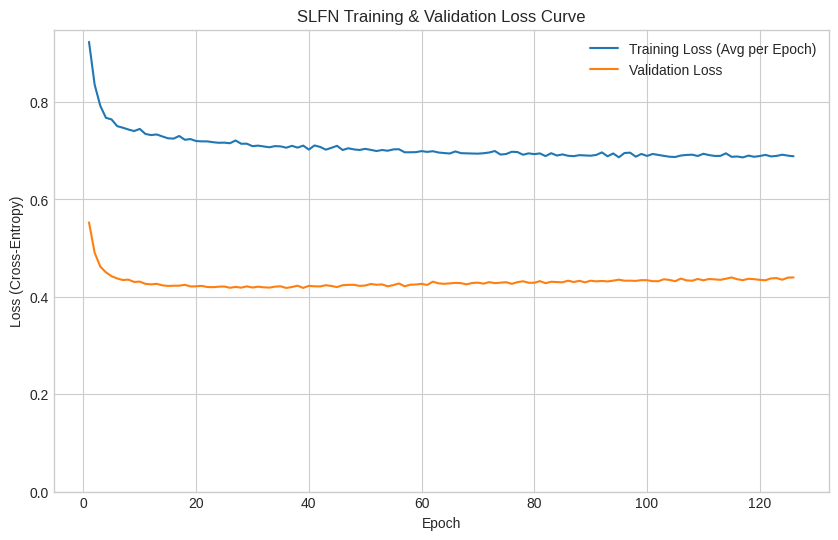

------------------------------


In [5]:
if titanic_data_available:
    print("\n--- Configuring and Training SLFN Model ---")

    input_size = X_titanic_train_final.shape[1] # Number of features
    hidden_size = 32      # Number of neurons in the hidden layer
    output_size = 1
    learning_rate = 0.005
    momentum = 0.9        # helps accelerate convergence
    l2_lambda = 0.01      # prevents overfitting
    epochs = 5000         # Maximum number of epochs
    batch_size = 32       # Number of samples per mini-batch
    patience = 100         # Early stopping patience (epochs to wait for improvement)

    # Instantiate the IMPROVED SLFN
    SLFN = SLFN(input_size=input_size, hidden_size=hidden_size,
                                  output_size=output_size, learning_rate=learning_rate,
                                  momentum=momentum, l2_lambda=l2_lambda)
    # Train the model
    SLFN.train(X_titanic_train_final, y_titanic_train_final,
                        X_titanic_val, y_titanic_val,
                        epochs=epochs, batch_size=batch_size, patience=patience,
                        verbose=True, print_every=100)

    # Plot the loss curve over training epochs
    print("\nPlotting Training vs Validation Loss Curves...")
    plt.figure(figsize=(10, 6))
    # Ensure list lengths match for plotting (early stopping might truncate train losses)
    epochs_trained = len(SLFN.train_losses)
    plt.plot(range(1, epochs_trained + 1), SLFN.train_losses, label='Training Loss (Avg per Epoch)')
    # Plot validation loss up to the point training stopped
    plt.plot(range(1, epochs_trained + 1), SLFN.val_losses[:epochs_trained], label='Validation Loss')
    plt.title('SLFN Training & Validation Loss Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (Cross-Entropy)') # Note: Train loss includes L2 effect if monitored during compute_loss
    plt.legend()
    plt.grid(True)
    plt.ylim(bottom=0) # Ensure y-axis starts at 0 for loss plots
    plt.show()
    print("-" * 30)

else:
    print("Skipping SLFN training as Titanic data is not available.")

## SLFN Visualization - Confusion Matrix & AUC-ROC Curve

Compute and plot the confusion matrix for the SLFN predictions on the Titanic test set.


--- Evaluating Improved SLFN Model on FINAL Test Set ---
Test Accuracy: 0.7989

Test Classification Report (Precision, Recall, F1-score):
                  precision    recall  f1-score   support

Not Survived (0)       0.81      0.88      0.84       110
    Survived (1)       0.78      0.67      0.72        69

        accuracy                           0.80       179
       macro avg       0.79      0.77      0.78       179
    weighted avg       0.80      0.80      0.80       179


Computing and plotting Confusion Matrix...


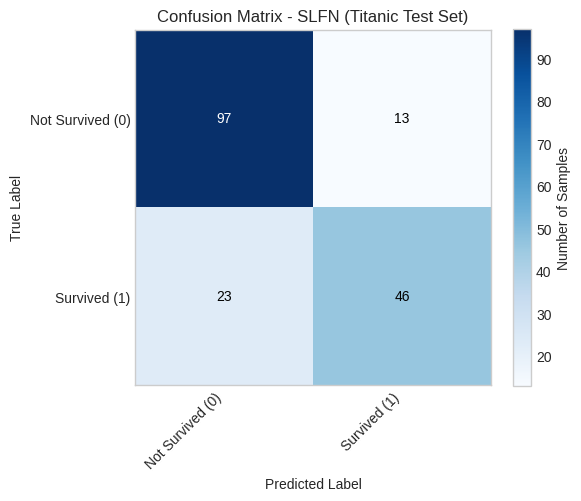


Plotting AUC-ROC Curve...


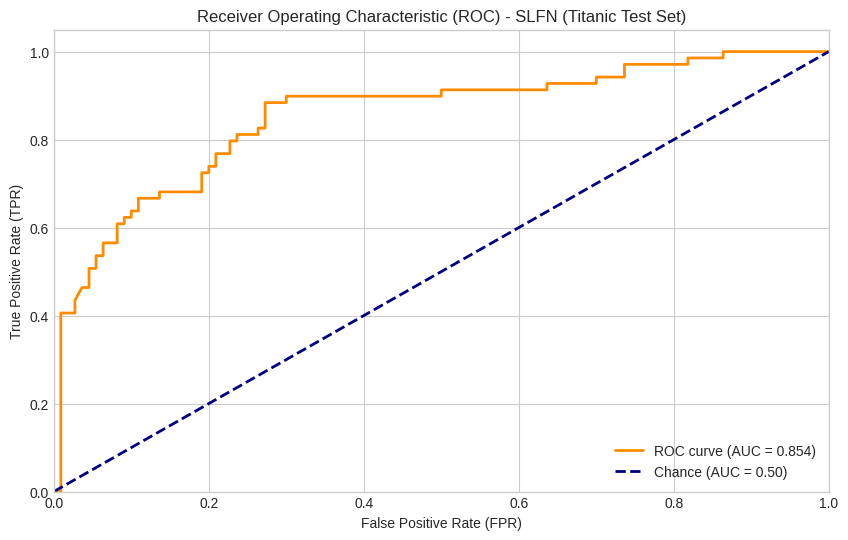

Area Under Curve (AUC) Score: 0.8542
------------------------------


In [6]:
if titanic_data_available and 'SLFN' in locals():
    print("\n--- Evaluating Improved SLFN Model on FINAL Test Set ---")

    # Task 3, Step 3 & 4: Evaluate the model (Metrics)
    y_pred_titanic = SLFN.predict(X_titanic_test)
    y_pred_proba_titanic = SLFN.predict_proba(X_titanic_test)

    # Calculate Accuracy
    accuracy_titanic = accuracy_score(y_titanic_test, y_pred_titanic)
    print(f"Test Accuracy: {accuracy_titanic:.4f}")

    # Calculate Precision, Recall, F1-score and print Classification Report
    print("\nTest Classification Report (Precision, Recall, F1-score):")
    target_names = ["Not Survived (0)", "Survived (1)"]
    print(classification_report(y_titanic_test, y_pred_titanic, target_names=target_names, zero_division=0))

    # Task 3, Step 5: Compute and Plot Confusion Matrix
    print("\nComputing and plotting Confusion Matrix...")
    cm_titanic = confusion_matrix(y_titanic_test, y_pred_titanic)
    plt.figure(figsize=(6, 5))
    plt.imshow(cm_titanic, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion Matrix - SLFN (Titanic Test Set)')
    plt.colorbar(label='Number of Samples')
    tick_marks = np.arange(len(target_names))
    plt.xticks(tick_marks, target_names, rotation=45, ha="right")
    plt.yticks(tick_marks, target_names)
    # Add text annotations
    thresh = cm_titanic.max() / 2.
    for i in range(cm_titanic.shape[0]):
        for j in range(cm_titanic.shape[1]):
            plt.text(j, i, format(cm_titanic[i, j], 'd'),
                     ha="center", va="center",
                     color="white" if cm_titanic[i, j] > thresh else "black")
    plt.grid(False)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.show()

    # Task 3, Step 7: Plot the AUC-ROC curve
    print("\nPlotting AUC-ROC Curve...")
    fpr, tpr, thresholds = roc_curve(y_titanic_test, y_pred_proba_titanic)
    roc_auc = auc(fpr, tpr) # Calculate Area Under Curve

    plt.figure(figsize=(10, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Chance (AUC = 0.50)') # Diagonal line for reference
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05]) # Slightly above 1.0 to ensure curve visibility
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Receiver Operating Characteristic (ROC) - SLFN (Titanic Test Set)')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    print(f"Area Under Curve (AUC) Score: {roc_auc:.4f}")
    print("-" * 30)

else:
    print("Skipping SLFN evaluation as prerequisites (data/model) are not met.")